# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from collections import Counter

from utils.helper import IQR, cap_outliers_iqr, standard_scale, skewness, boxcox_transformation, VIF, shannon_entropy, train_test_split, plot_model_loss
from utils.metrics import classification_metrics, roc_auc_score, confusion_matrix
from utils.models import SVM, LogisticRegression
from utils.tuner import nested_cross_validation, generate_parameters

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Loading

In [2]:
RED_WINE_DATA = "./data/winequality-red.csv"
WHITE_WINE_DATA = "./data/winequality-white.csv"


In [3]:
wine_red = pd.read_csv(RED_WINE_DATA, sep=";")
wine_white = pd.read_csv(WHITE_WINE_DATA, sep=";")


In [4]:
red = wine_red.copy()
white = wine_white.copy()
red['wine_type'] = 'red'
white['wine_type'] = 'white'

# Combine the datasets
wines = pd.concat([red, white],axis=0, ignore_index=True)


# EDA

## Summary Statistics

In [5]:
wine_red.shape


(1599, 12)

In [6]:
wine_white.shape


(4898, 12)

In [7]:
wines.shape


(6497, 13)

In [8]:
wines.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [9]:
wines.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Missing Value Analysis

In [10]:
round((wines.isnull().sum() / len(wine_red)) * 100, 2)


fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
wine_type               0.0
dtype: float64

## Data Distribution

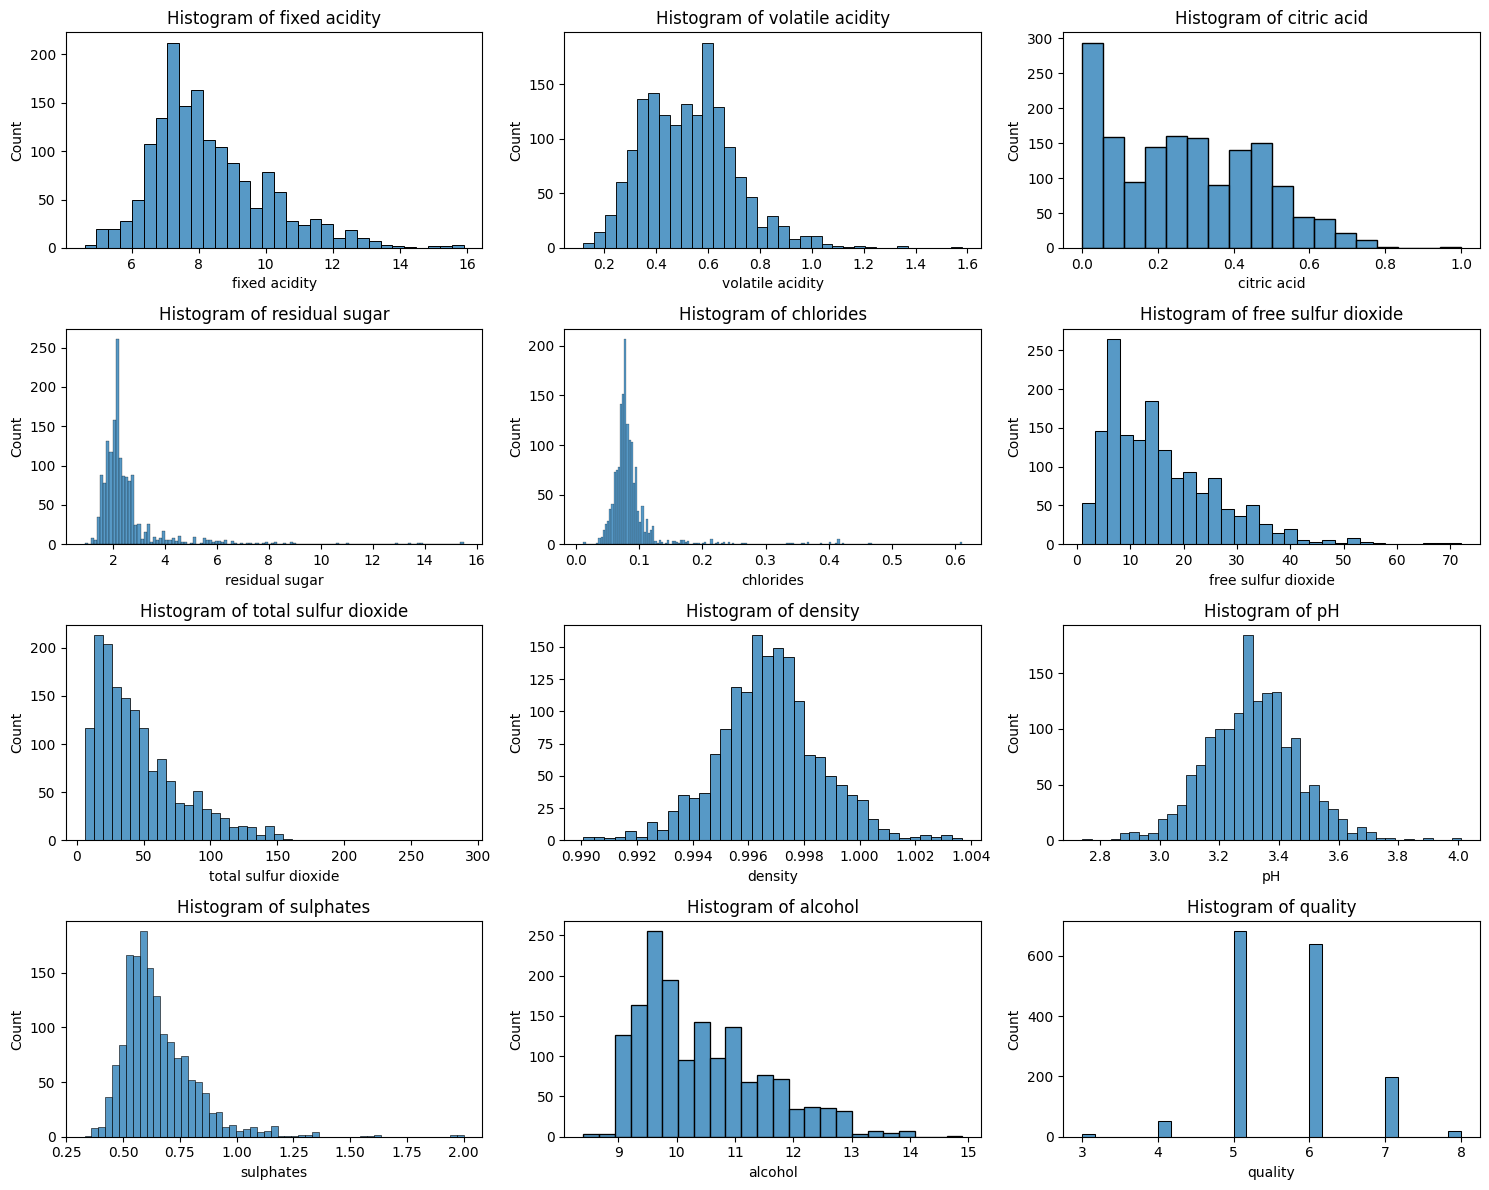

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, col in enumerate(wine_red.columns):
    sns.histplot(data=wine_red, x=col, kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

# Turn off any unused axes (if less than 12 features)
for j in range(len(wine_red.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()

# Save the figure as a PNG file in your current directory
plt.savefig('wine_red_histograms.png', dpi=300)

plt.show()


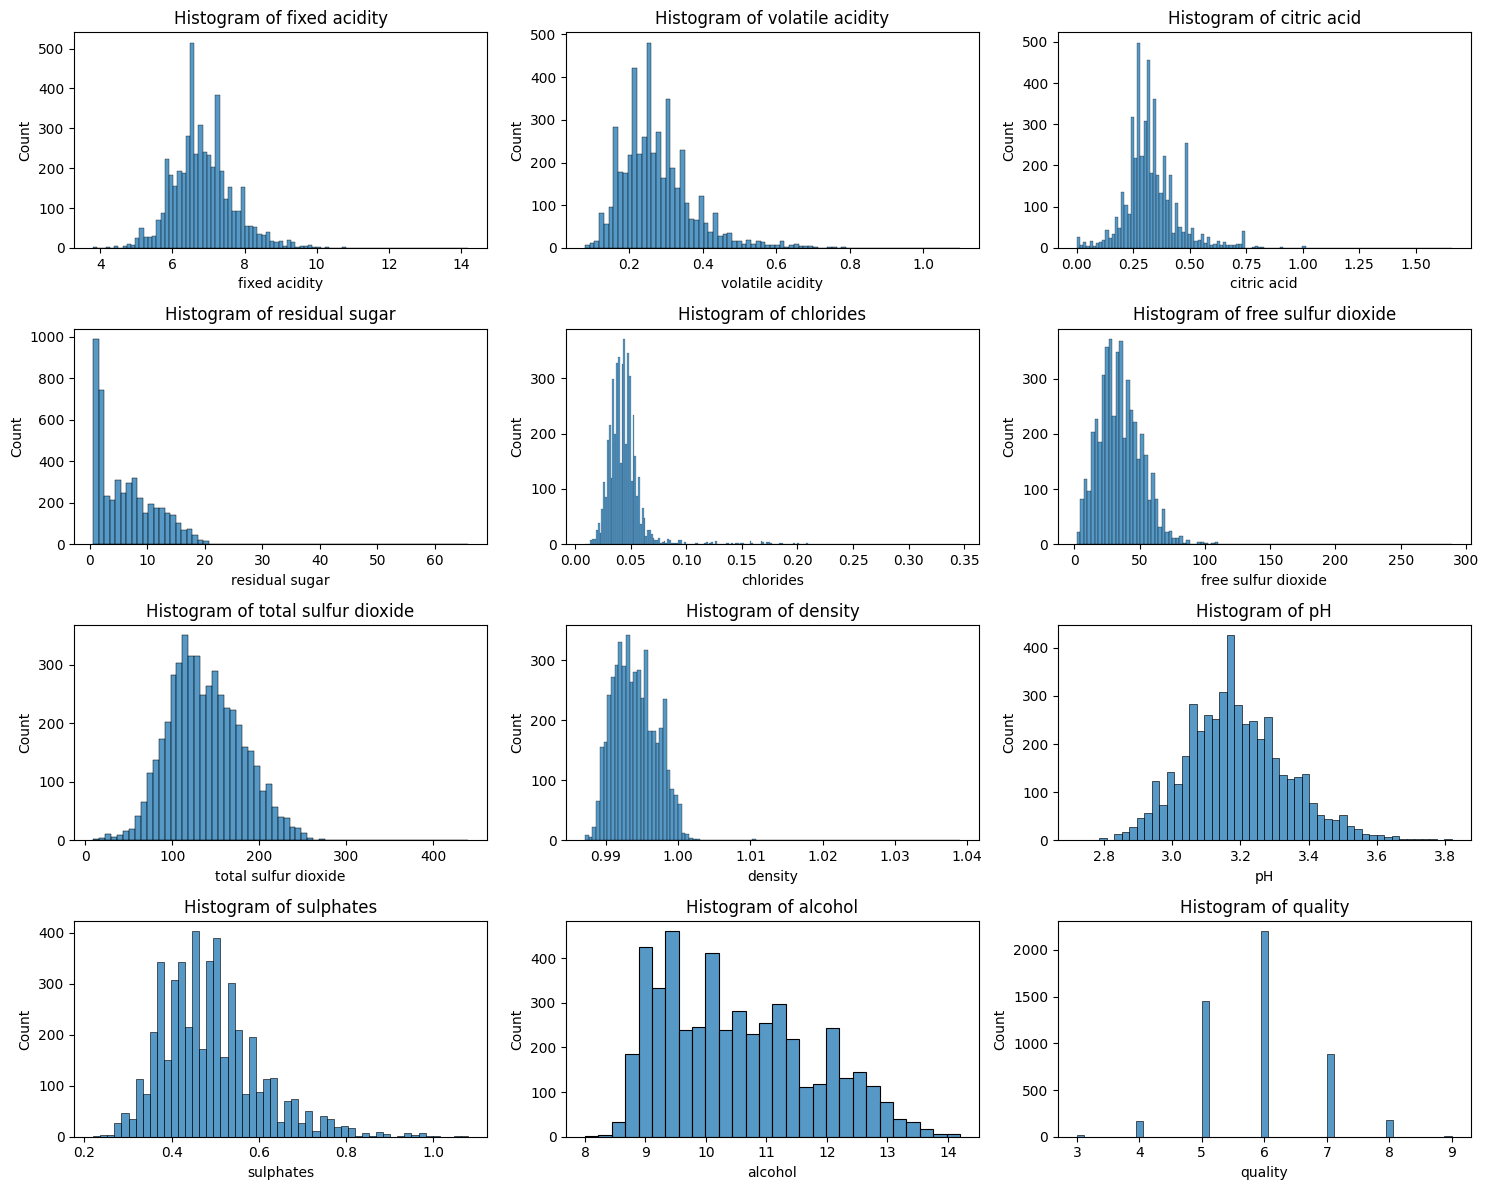

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, col in enumerate(wine_white.columns):
    sns.histplot(data=wine_white, x=col, kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

# Turn off any unused axes (if less than 12 features)
for j in range(len(wine_white.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('wine_white_histograms.png', dpi=300)
plt.show()


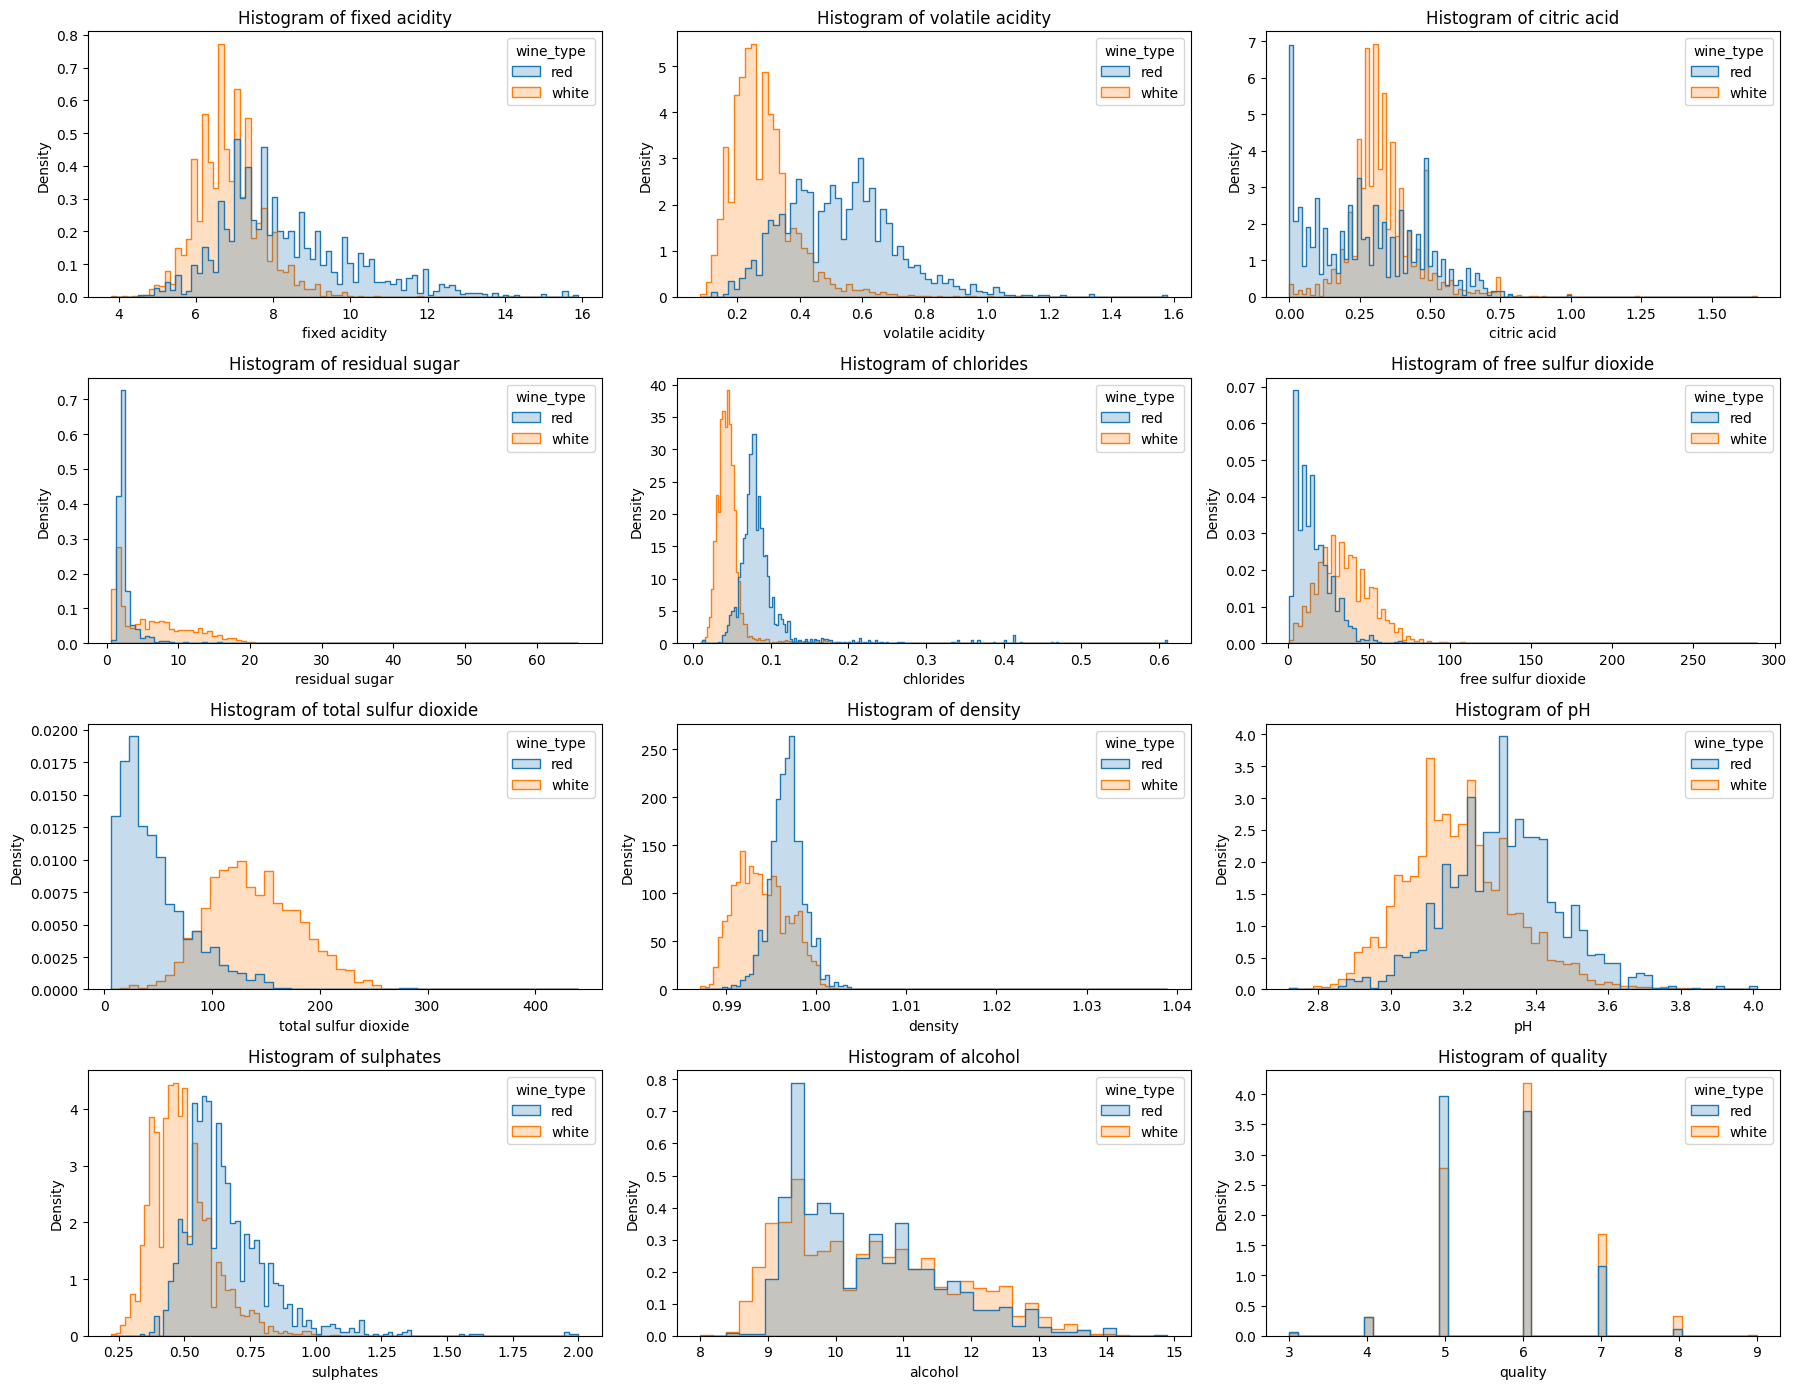

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wines.columns if col != 'wine_type']

# Plot histograms for each feature with hue for wine type
for i, col in enumerate(features):
    sns.histplot(data=wines, x=col, hue='wine_type', kde=False, ax=axes[i], 
                 element='step', stat='density', common_norm=False, legend=True)
    axes[i].set_title(f'Histogram of {col}')

# Hide unused axes if any
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('wines_histograms.png', dpi=300)
plt.show()


In [14]:
# Separate features
features = [col for col in wines.columns if col != 'wine_type']


# Store results
results = []

for col in features:
    stat, p = mannwhitneyu(wine_red[col], wine_white[col], alternative='two-sided')
    results.append({
        'Feature': col,
        'U-statistic': stat,
        'p-value': p,
        'Significant': 'Yes' if p >= 0.05 else 'No'
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values('p-value')

print(results_df)


                 Feature  U-statistic        p-value Significant
1       volatile acidity    7059623.5   0.000000e+00          No
4              chlorides    7407015.5   0.000000e+00          No
5    free sulfur dioxide    1186396.5   0.000000e+00          No
6   total sulfur dioxide     366639.5   0.000000e+00          No
9              sulphates    6509961.0   0.000000e+00          No
0          fixed acidity    6138507.0  1.438930e-255          No
7                density    6059284.5  1.453091e-237          No
8                     pH    5681839.5  5.472258e-162          No
3         residual sugar    2569687.0   5.634073e-95          No
2            citric acid    3070088.5   1.312558e-38          No
11               quality    3311514.0   3.634341e-23          No
10               alcohol    3829043.5   1.818451e-01         Yes


## Data Encoding

In [15]:
wines_encoded = pd.get_dummies(wines, columns=['wine_type'], drop_first=False)

In [16]:
wines_encoded.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type_red',
       'wine_type_white'],
      dtype='object')

## Correlation Analysis

<Figure size 2000x2000 with 0 Axes>

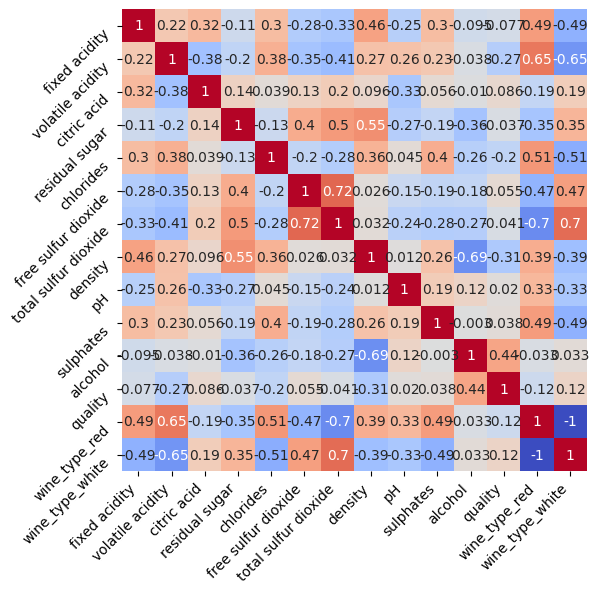

In [17]:
fig = plt.figure(figsize=(20, 20))

correlation = wines_encoded[wines_encoded.columns].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")

plt.savefig('correlation_wines.png', dpi=300)


plt.show()


## Target Base Analysis

In [18]:
def wine_quality_categorization(quality):
    if quality >= 6:
        return "good"
    else:
        return "bad"

In [19]:
wines_encoded["quality"] = wines_encoded["quality"].apply(wine_quality_categorization)


In [20]:
wines_encoded

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,bad,True,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,bad,True,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,bad,True,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,good,True,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,bad,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,good,False,True
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,bad,False,True
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,good,False,True
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,good,False,True


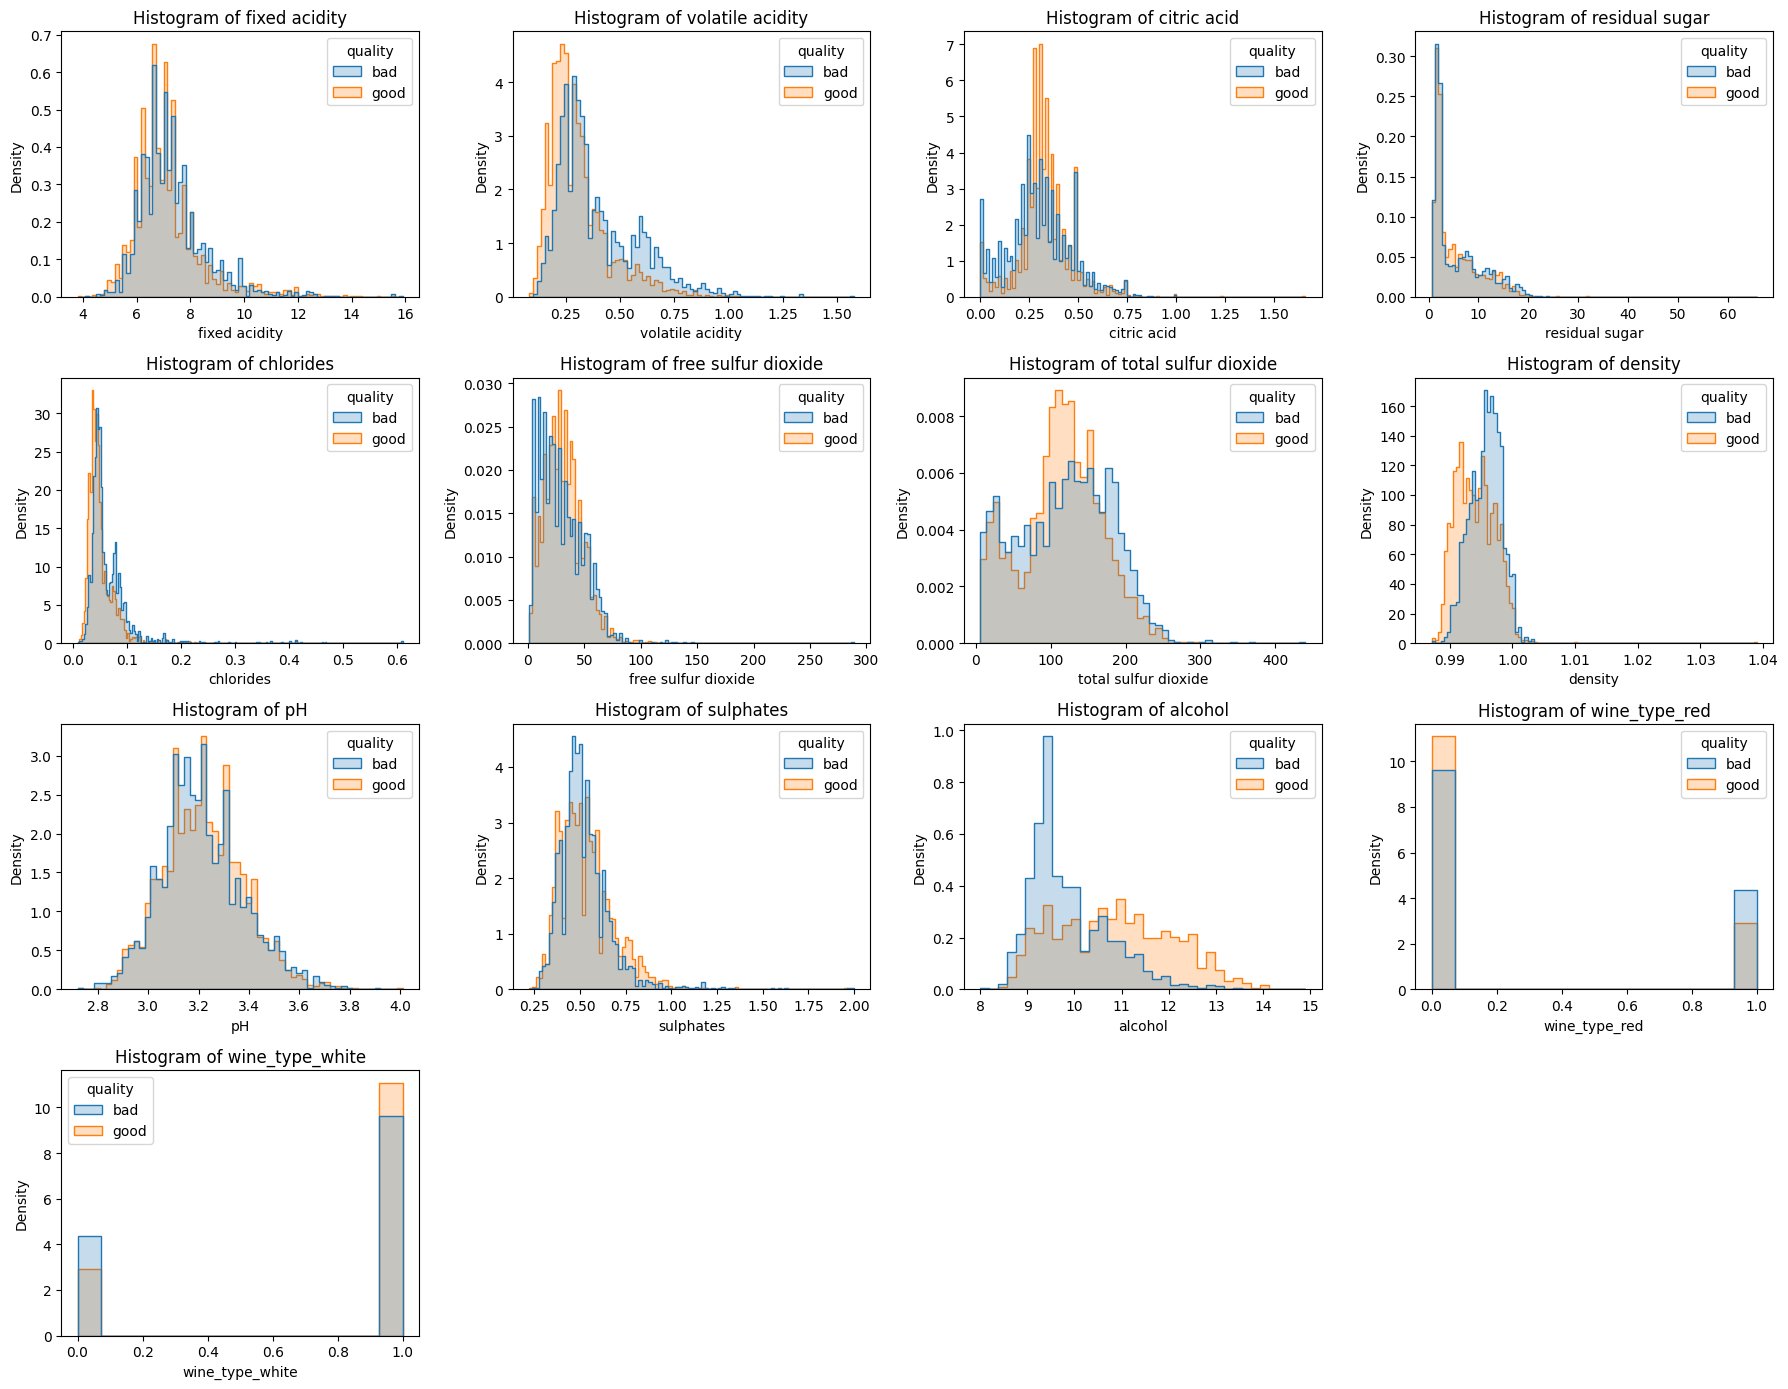

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wines_encoded.columns if col != 'quality']

for i, col in enumerate(features):
    sns.histplot(data=wines_encoded, x=col, hue='quality', kde=False, ax=axes[i], 
                 element='step', stat='density', common_norm=False, legend=True)
    axes[i].set_title(f'Histogram of {col}')

# Hide unused axes if any
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('dist_target_based.png', dpi=300)

plt.show()


In [22]:
# Separate features
features = [col for col in wines_encoded.columns if col != 'quality']
print(features)
wine_good_quality = wines_encoded[wines_encoded['quality'] == "good"]
wine_bad_quality = wines_encoded[wines_encoded['quality'] == "bad"]
print(wine_good_quality.shape)
print(wine_bad_quality.shape)
# Store results
results = []

for col in features:
    stat, p = mannwhitneyu(wine_good_quality[col], wine_bad_quality[col], alternative='two-sided')
    results.append({
        'Feature': col,
        'U-statistic': stat,
        'p-value': p,
        'Significant': 'Yes' if p >= 0.05 else 'No'
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values('p-value')

print(results_df)


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'wine_type_red', 'wine_type_white']
(4113, 14)
(2384, 14)
                 Feature  U-statistic        p-value Significant
10               alcohol    7225914.5  2.946818e-223          No
7                density    3269176.5  2.625686e-111          No
1       volatile acidity    3351095.5  1.109625e-100          No
4              chlorides    3409001.0   2.029655e-93          No
11         wine_type_red    4391820.0   5.599396e-21          No
12       wine_type_white    5413572.0   5.599396e-21          No
0          fixed acidity    4361743.0   1.102637e-13          No
2            citric acid    5442802.0   1.211135e-13          No
5    free sulfur dioxide    5345783.0   1.188641e-09          No
6   total sulfur dioxide    4597265.5   2.769081e-05          No
9              sulphates    5071869.5   2.021005e-02   

## Outlier Analysis

In [23]:
IQR(wines_encoded)


Outlier Percentages per Column
fixed acidity           1.323688
volatile acidity        0.723411
citric acid             0.230876
residual sugar          0.046175
chlorides               2.047099
free sulfur dioxide     0.123134
total sulfur dioxide    0.015392
density                 0.015392
pH                      0.030783
sulphates               0.538710
alcohol                 0.000000
dtype: float64


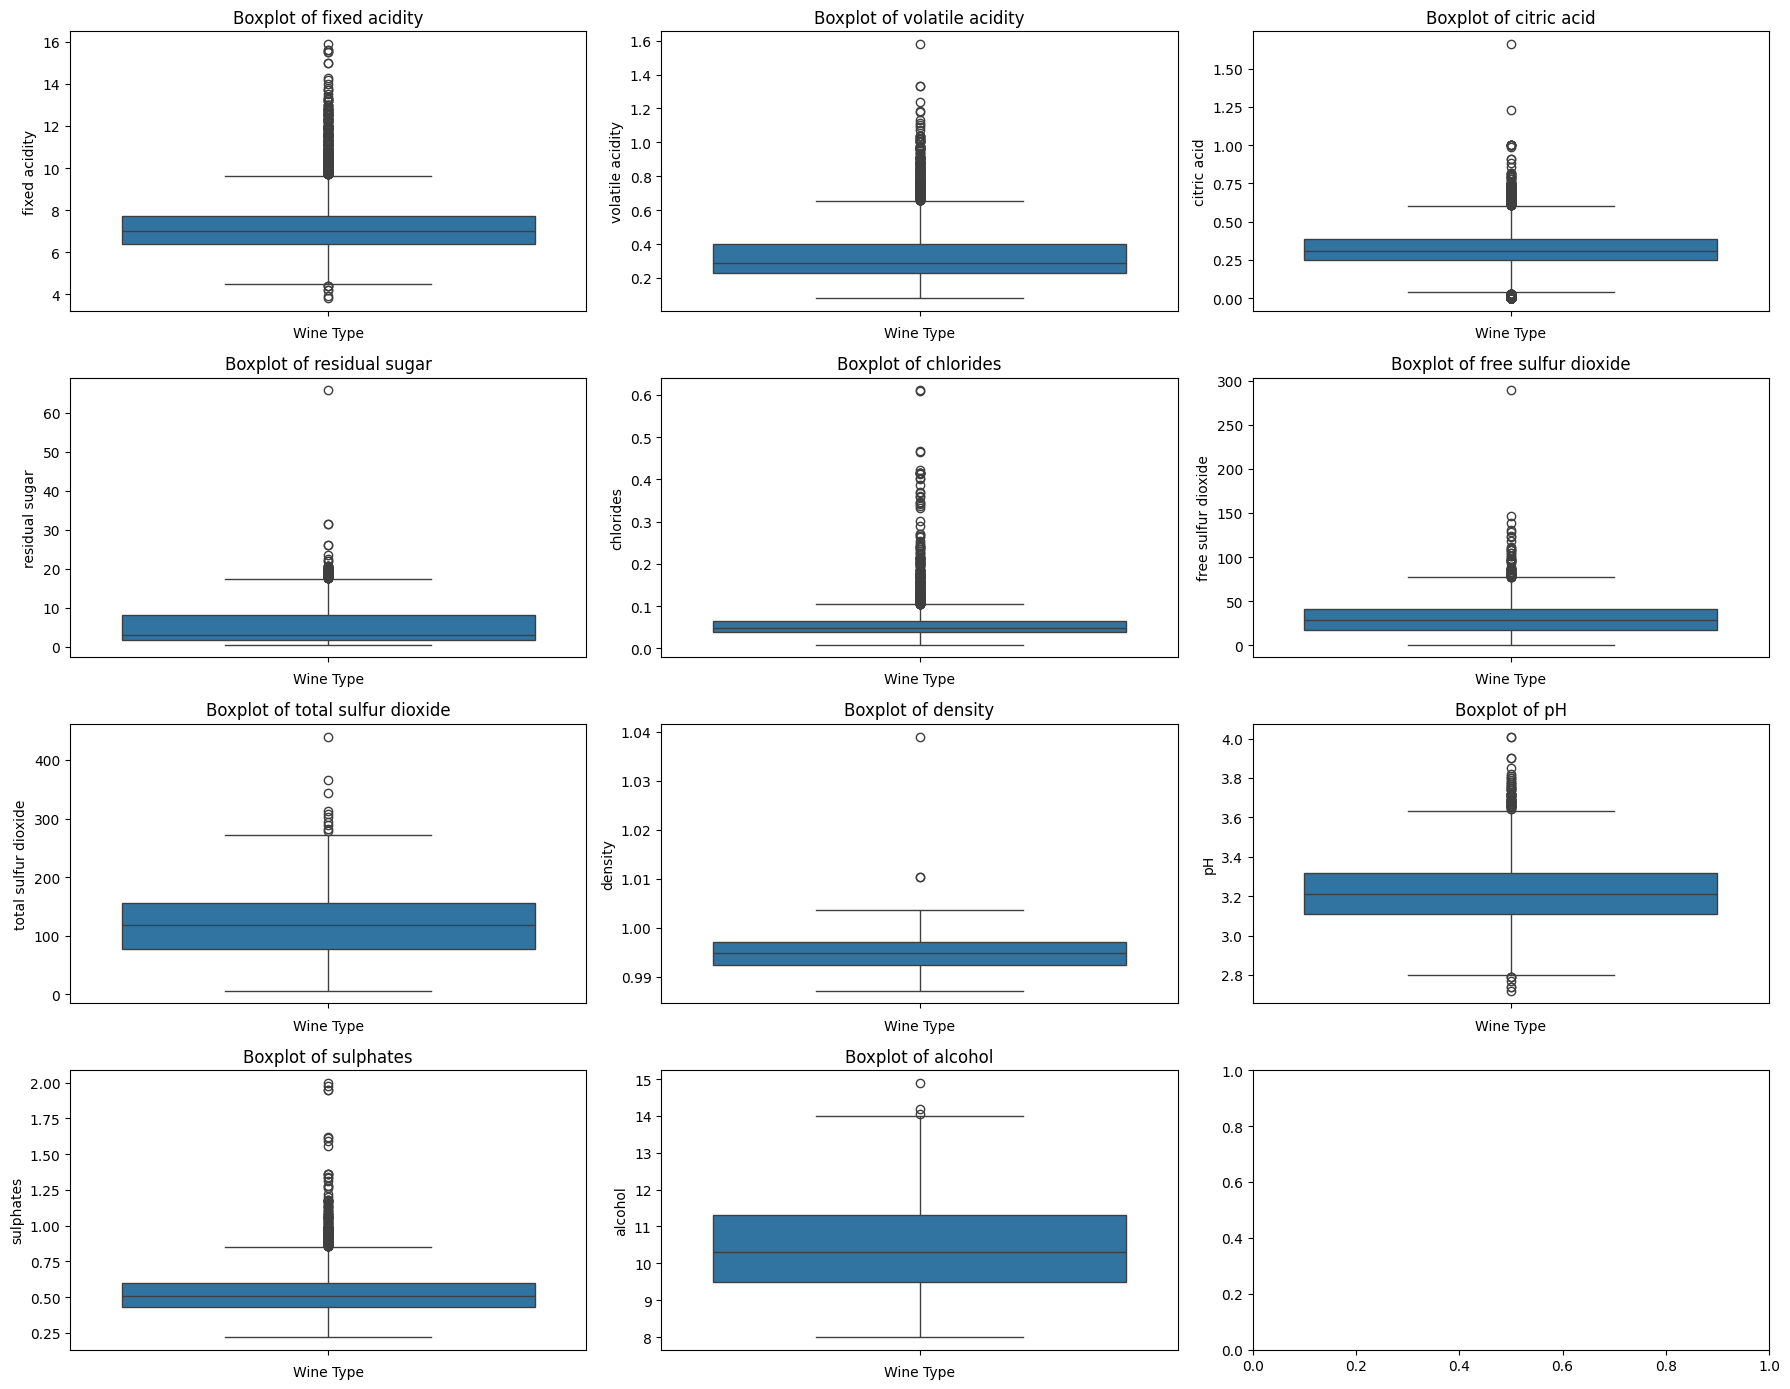

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wines_encoded.columns if col != 'quality' and col!= 'wine_type_red' and col!= 'wine_type_white']

for i, col in enumerate(features):
    sns.boxplot(data=wines_encoded, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('Wine Type')
    axes[i].set_ylabel(col)


plt.tight_layout()
plt.savefig('wine_boxplots.png', dpi=300)

plt.show()


In [25]:
wines_encoded_capped = cap_outliers_iqr(wines_encoded)

In [26]:
wines_encoded.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type_red',
       'wine_type_white'],
      dtype='object')

In [27]:
IQR(wines_encoded)


Outlier Percentages per Column
fixed acidity           1.323688
volatile acidity        0.723411
citric acid             0.230876
residual sugar          0.046175
chlorides               2.047099
free sulfur dioxide     0.123134
total sulfur dioxide    0.015392
density                 0.015392
pH                      0.030783
sulphates               0.538710
alcohol                 0.000000
dtype: float64


In [28]:
wines_encoded_capped.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.200038,0.338773,0.318182,5.435847,0.054379,30.480068,115.737340,0.994692,3.218482,0.530009,10.491801
std,1.231132,0.160810,0.143153,4.698915,0.024747,17.389961,56.483342,0.002955,0.160700,0.141460,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,11.600000,0.910000,0.810000,27.000000,0.146000,113.000000,393.000000,1.010940,3.950000,1.110000,14.900000


In [29]:
wines_encoded_capped.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type_red',
       'wine_type_white'],
      dtype='object')

## Data Scaling

In [30]:
wines_scaled = standard_scale(wines_encoded_capped)


## Skewness & Data Transformation

In [31]:
for i in wines_scaled.columns:
    if i in ['quality', 'wine_type_red', 'wine_type_white']:
        continue 
    print(f"skewness of {i} :", skewness(wines_scaled[i].values))
    

skewness of fixed acidity : 1.312744051359684
skewness of volatile acidity : 1.2968139129434146
skewness of citric acid : 0.26183140654510856
skewness of residual sugar : 1.1599078318374028
skewness of chlorides : 1.595113333606966
skewness of free sulfur dioxide : 0.7248836328092017
skewness of total sulfur dioxide : -0.01171637202367966
skewness of density : 0.03798188787832216
skewness of pH : 0.38006592573837567
skewness of sulphates : 1.0898923147918305
skewness of alcohol : 0.5657177290985274


In [32]:
cols_to_exclude = ['quality', 'wine_type_red', 'wine_type_red']
cols_to_check = [col for col in wines_scaled.columns if col not in cols_to_exclude]

wines_transformed, lambdas_red = boxcox_transformation(wines_scaled, cols_to_check)

Skipped columns (skewness ≤ 0.5): ['citric acid', 'total sulfur dioxide', 'density', 'pH', 'wine_type_white']


In [33]:
for i in wines_transformed.columns:
    if i in ['quality', 'wine_type_red', 'wine_type_white']:
        continue 
    print(f"skewness of {i} :", skewness(wines_transformed[i].values))
    

skewness of fixed acidity : 0.10407455369529993
skewness of volatile acidity : 0.1316530748235699
skewness of citric acid : 0.26183140654510856
skewness of residual sugar : 0.024501230476804844
skewness of chlorides : 0.21764792504028962
skewness of free sulfur dioxide : -0.0740438030808129
skewness of total sulfur dioxide : -0.01171637202367966
skewness of density : 0.03798188787832216
skewness of pH : 0.38006592573837567
skewness of sulphates : 0.012601435225746175
skewness of alcohol : -0.015840153472630826


## Multicolinearity Analysis

In [34]:
for col in wines_transformed.columns:
    if wines_transformed[col].dtype == 'bool':
        wines_transformed[col] = wines_transformed[col].astype(float)
        
X = wines_transformed.drop(columns=['quality']) 


vif_df = VIF(X)
print(vif_df.sort_values(by='VIF', ascending=False))


                 Feature       VIF
0          fixed acidity       inf
11         wine_type_red       inf
12       wine_type_white       inf
7                density  3.620767
6   total sulfur dioxide  3.361592
5    free sulfur dioxide  2.071849
8                     pH  1.956671
4              chlorides  1.765558
10               alcohol  1.442814
2            citric acid  1.265885
3         residual sugar  0.998863
1       volatile acidity  0.911803
9              sulphates  0.311074


## Target Balance Analysis

In [35]:
entropy = shannon_entropy(wines_transformed["quality"])
entropy


0.9482924220354461

In [36]:
def plot_target_distribution(df, target_col):
    # Calculate value counts and percentages
    counts = df[target_col].value_counts()
    percentages = counts / counts.sum() * 100

    # Prepare the plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=counts.index, y=percentages, palette='viridis')

    # Add percentage labels on top of bars
    for p, perc in zip(ax.patches, percentages):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 1,
                f'{perc:.1f}%', ha='center', fontsize=12)

    plt.ylabel('Percentage (%)')
    plt.xlabel(target_col)
    plt.title(f'Distribution of {target_col} (in %)')
    plt.ylim(0, percentages.max() + 10)
    plt.show()


/var/folders/dd/6c1yw5255dd59m89xkwwf4qr0000gn/T/ipykernel_53256/533642084.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=percentages, palette='viridis')


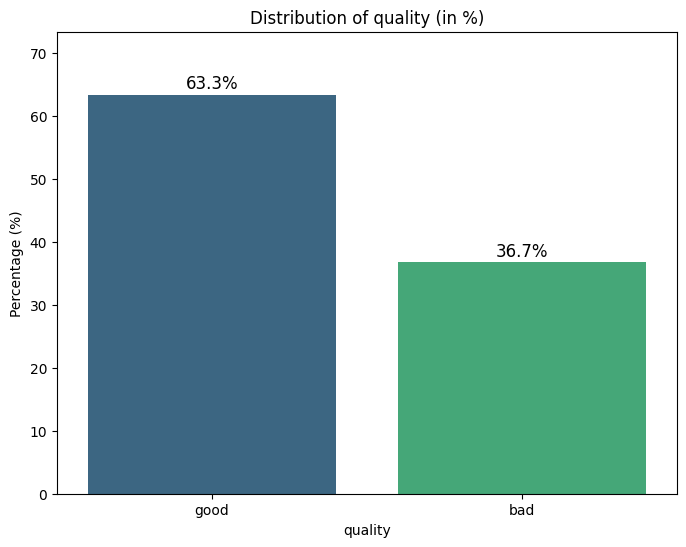

In [37]:
plot_target_distribution(wines_transformed, 'quality')


# Modeling

## Train - Test Splitting

In [38]:
X = wines_transformed.drop(["quality", "wine_type_white"], axis=1)
y = wines_transformed["quality"]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## SVM

In [40]:
svm = SVM(kernel='linear', learning_rate=0.0001, lambda_l2=0.001, n_iters=100)  # linear SVM with SGD

svm.fit(X_train, y_train, X_test=X_test, y_test = y_test)

preds_svm = svm.predict(X_test)
metrics = classification_metrics(y_test, preds_svm)
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Epoch 1: Train Loss=0.8113, Train Accuracy=0.6503 | Test Loss=0.8095, Test Accuracy=0.6520
Epoch 2: Train Loss=0.7235, Train Accuracy=0.6547 | Test Loss=0.7179, Test Accuracy=0.6543
Epoch 3: Train Loss=0.6989, Train Accuracy=0.6658 | Test Loss=0.6920, Test Accuracy=0.6690
Epoch 4: Train Loss=0.6820, Train Accuracy=0.6839 | Test Loss=0.6749, Test Accuracy=0.6905
Epoch 5: Train Loss=0.6687, Train Accuracy=0.6968 | Test Loss=0.6622, Test Accuracy=0.7028
Epoch 6: Train Loss=0.6573, Train Accuracy=0.7080 | Test Loss=0.6520, Test Accuracy=0.7159
Epoch 7: Train Loss=0.6471, Train Accuracy=0.7137 | Test Loss=0.6433, Test Accuracy=0.7182
Epoch 8: Train Loss=0.6380, Train Accuracy=0.7187 | Test Loss=0.6358, Test Accuracy=0.7190
Epoch 9: Train Loss=0.6300, Train Accuracy=0.7216 | Test Loss=0.6297, Test Accuracy=0.7175
Epoch 10: Train Loss=0.6234, Train Accuracy=0.7268 | Test Loss=0.6248, Test Accuracy=0.7167
Epoch 11: Train Loss=0.6181, Train Accuracy=0.7272 | Test Loss=0.6212, Test Accuracy=0.72

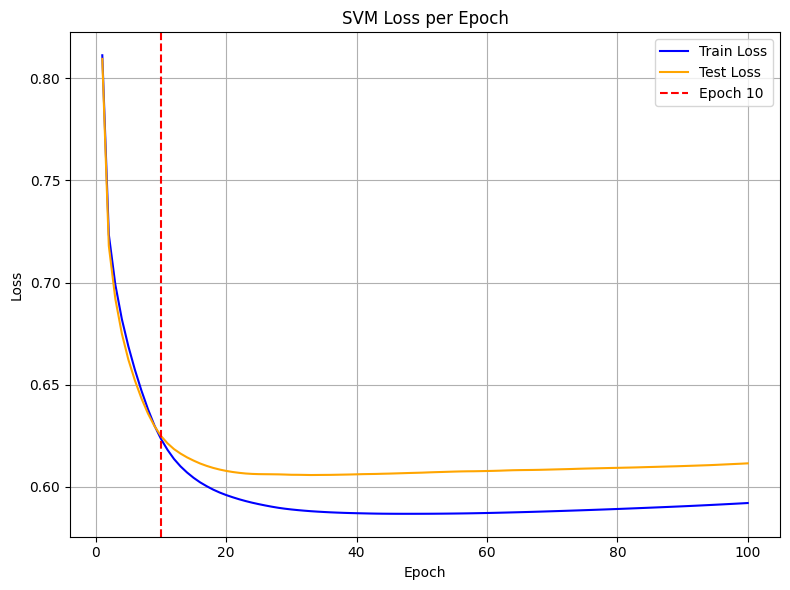

In [41]:
plot_model_loss(svm, vline_epoch=10, train_color='blue', test_color='orange')


## Logistic Regression

In [42]:
logreg = LogisticRegression(
    learning_rate=1e-5, n_iters=500, kernel='linear', gamma=0.1,
    positive_class='good', l2=0.001
)
logreg.fit(X_train, y_train, X_test=X_test, y_test = y_test)

preds_logreg = logreg.predict(X_test)
metrics = classification_metrics(y_test, preds_logreg)
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

[Epoch 1/500] Train Loss: 0.6798 | Accuracy: 0.6229 || Test Loss: 0.6789 | Accuracy: 0.6490
[Epoch 2/500] Train Loss: 0.6701 | Accuracy: 0.6222 || Test Loss: 0.6683 | Accuracy: 0.6490
[Epoch 3/500] Train Loss: 0.6628 | Accuracy: 0.6220 || Test Loss: 0.6604 | Accuracy: 0.6482
[Epoch 4/500] Train Loss: 0.6570 | Accuracy: 0.6218 || Test Loss: 0.6541 | Accuracy: 0.6467
[Epoch 5/500] Train Loss: 0.6524 | Accuracy: 0.6224 || Test Loss: 0.6490 | Accuracy: 0.6467
[Epoch 6/500] Train Loss: 0.6486 | Accuracy: 0.6224 || Test Loss: 0.6448 | Accuracy: 0.6451
[Epoch 7/500] Train Loss: 0.6453 | Accuracy: 0.6208 || Test Loss: 0.6411 | Accuracy: 0.6420
[Epoch 8/500] Train Loss: 0.6424 | Accuracy: 0.6193 || Test Loss: 0.6379 | Accuracy: 0.6436
[Epoch 9/500] Train Loss: 0.6398 | Accuracy: 0.6191 || Test Loss: 0.6351 | Accuracy: 0.6390
[Epoch 10/500] Train Loss: 0.6375 | Accuracy: 0.6191 || Test Loss: 0.6325 | Accuracy: 0.6390
[Epoch 11/500] Train Loss: 0.6354 | Accuracy: 0.6185 || Test Loss: 0.6301 | Acc

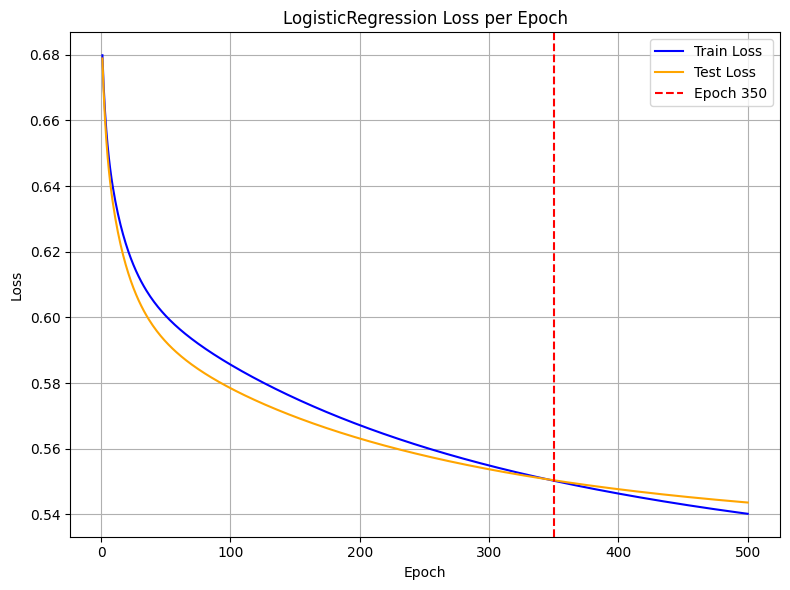

In [43]:
plot_model_loss(logreg, vline_epoch=350, train_color='blue', test_color='orange')

## Hyperparameter Tuning with CV & Model Comparison

In [44]:
svm_param_grid = {
    'learning_rate':[0.01, 0.1],
    'lambda_l2':[0.01, 0.1],
    'kernel' :['rbf', 'poly'],
    'gamma' : [0.01, 0.1],
    'C' :[0.01, 0.1]
}

In [45]:
svm_to_opt = SVM()

In [46]:
svm_scores, svm_params = nested_cross_validation(
        X_train, y_train, svm_to_opt, svm_param_grid, outer_k=5, inner_k=5, random_state=42
    )

Outer CV: 100%|██████████| 5/5 [23:34:13<00:00, 16970.78s/it]         


In [47]:
best_fold_idx = np.argmax(svm_scores)  
best_params = svm_params[best_fold_idx]

print("Best parameters (from best fold):", best_params)
print("Best fold score:", svm_scores[best_fold_idx])

Best parameters (from best fold): {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf', 'lambda_l2': 0.01, 'learning_rate': 0.01}
Best fold score: 0.7644230769230769


In [48]:
print("\nCross-validated performance:")
print(f"Mean accuracy: {np.mean(svm_scores):.3f} ± {np.std(svm_scores):.3f}")


Cross-validated performance:
Mean accuracy: 0.746 ± 0.015


In [49]:
logreg_to_opt = LogisticRegression()

In [50]:
lr_param_grid = {
    'learning_rate':[0.001, 0.01],
    'l2':[0.001, 0.01],
    'kernel' :['rbf', 'poly'],
    'gamma' : [0.001, 0.01],
    'degree': [2,3],
    'coef0': [1.0]

}

In [51]:
lr_scores, lr_params = nested_cross_validation(
        X_train, y_train, logreg_to_opt, lr_param_grid, outer_k=5, inner_k=5, random_state=42
    )

Outer CV: 100%|██████████| 5/5 [10:39:33<00:00, 7674.77s/it]         


In [52]:
best_fold_idx = np.argmax(lr_scores)  
best_params = lr_params[best_fold_idx]

print("Best parameters (from best fold):", best_params)
print("Best fold score:", lr_scores[best_fold_idx])

Best parameters (from best fold): {'coef0': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'l2': 0.001, 'learning_rate': 0.01}
Best fold score: 0.6448508180943214


In [53]:
print("\nCross-validated performance:")
print(f"Mean accuracy: {np.mean(lr_scores):.3f} ± {np.std(lr_scores):.3f}")


Cross-validated performance:
Mean accuracy: 0.574 ± 0.106


## Model Analysis

### SVM

In [54]:
cm = confusion_matrix(y_test, preds_svm, positive_label='good')
cm

,Predicted good,Predicted not-good
Actual good,700,148
Actual not-good,201,250


In [55]:
svm_probs = svm.predict_proba(X_test)[:, 1]

In [56]:
fpr, tpr, auc = roc_auc_score(y_test, svm_probs, pos_label='good')

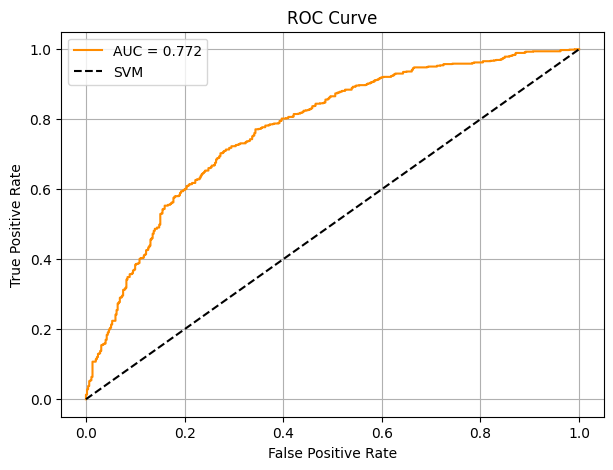

In [57]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

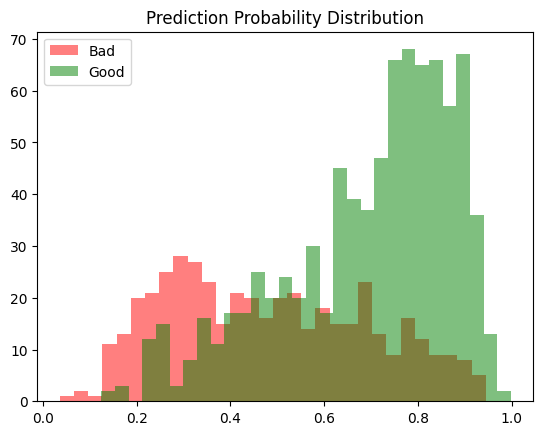

In [58]:
plt.hist(svm_probs[y_test == 'bad'], bins=30, alpha=0.5, label='Bad', color='red')
plt.hist(svm_probs[y_test == 'good'], bins=30, alpha=0.5, label='Good', color='green')
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()

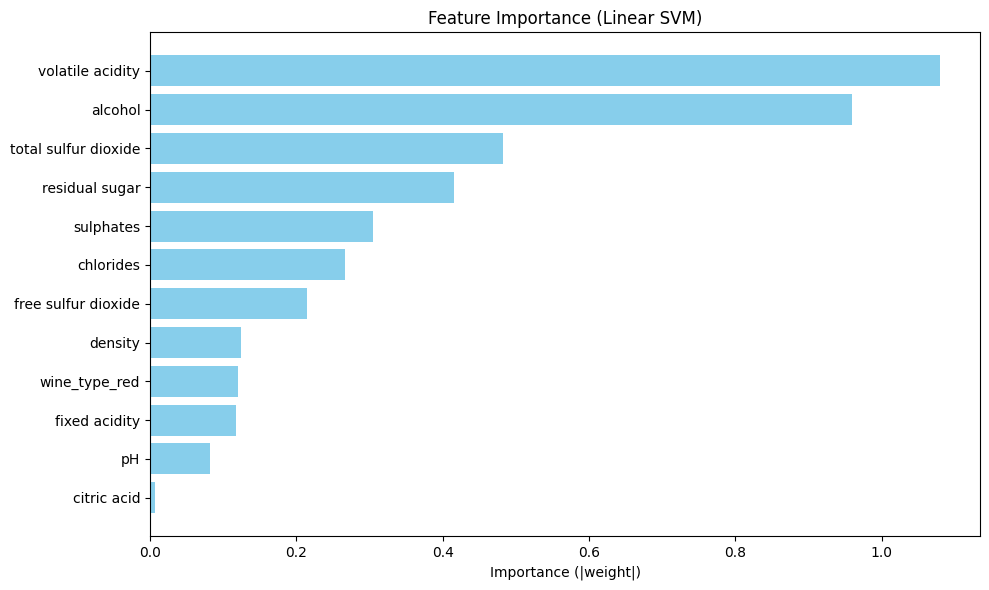

In [59]:
importances = svm.get_feature_importance(X.columns)
sorted_items = sorted(importances.items(), key=lambda x: -x[1])
features, values = zip(*sorted_items)

plt.figure(figsize=(10, 6))
plt.barh(features, values, color='skyblue')
plt.xlabel('Importance (|weight|)')
plt.title('Feature Importance (Linear SVM)')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

### Logistic Regression

In [60]:
cm = confusion_matrix(y_test, preds_logreg, positive_label='good')
cm

,Predicted good,Predicted not-good
Actual good,699,149
Actual not-good,227,224


In [61]:
logreg_probs = logreg.predict_proba(X_test)

In [62]:
fpr, tpr, auc = roc_auc_score(y_test, logreg_probs, pos_label='good')

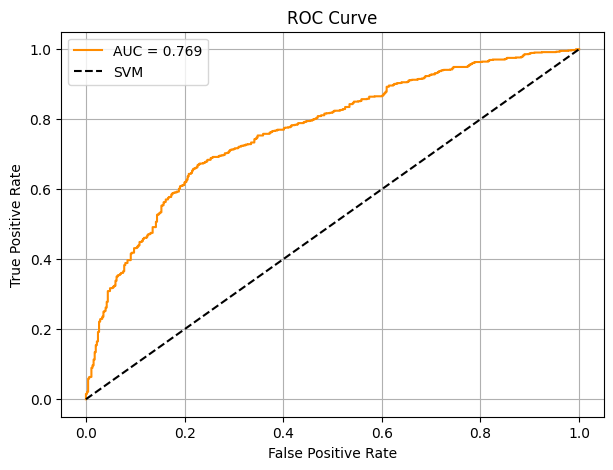

In [63]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

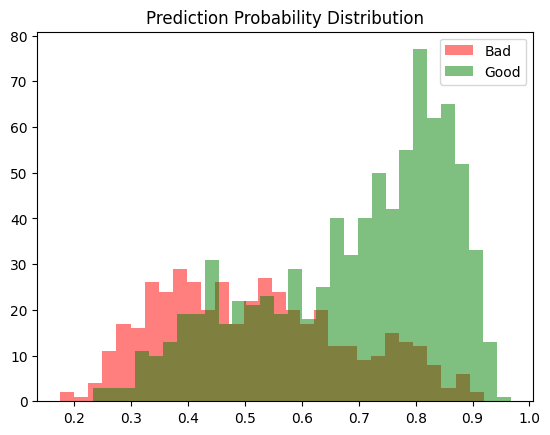

In [64]:
plt.hist(logreg_probs[y_test == 'bad'], bins=30, alpha=0.5, label='Bad', color='red')
plt.hist(logreg_probs[y_test == 'good'], bins=30, alpha=0.5, label='Good', color='green')
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()

In [65]:
feature_importance = logreg.get_feature_importance()

In [66]:
def plot_feature_importance(feature_importance, feature_names):
    indices = np.argsort(np.abs(feature_importance))[::-1]
    sorted_importance = feature_importance[indices]
    sorted_features = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Feature Importance (weight)')
    plt.title('Feature Importance for Logistic Regression (Linear Kernel)')
    plt.gca().invert_yaxis()  # highest on top

    # Optional: add values on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

    plt.show()

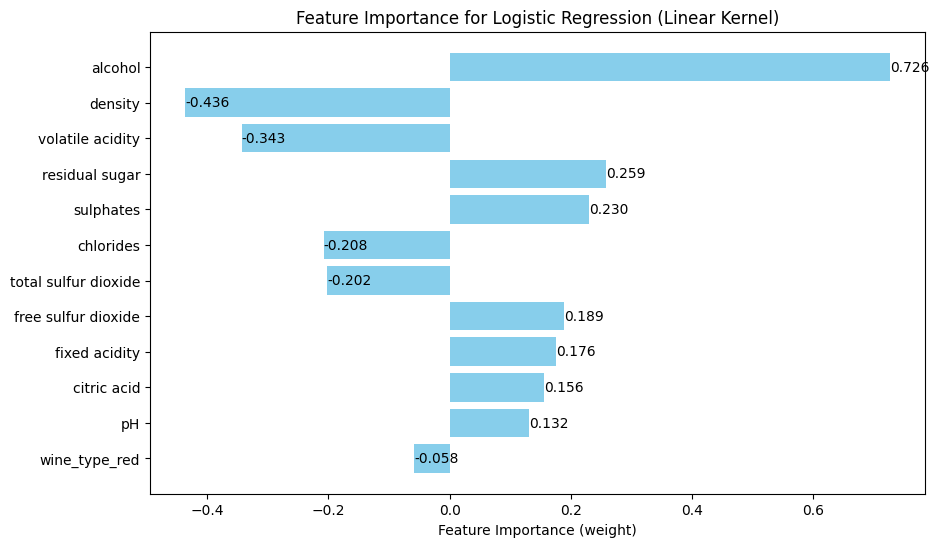

In [67]:
plot_feature_importance(feature_importance, X.columns)